### Veamos algunos ejemplos de los datos (imagenes de numeros) que tenemos 

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

Modalidades detectadas: ['m0', 'm1', 'm2', 'm3', 'm4']


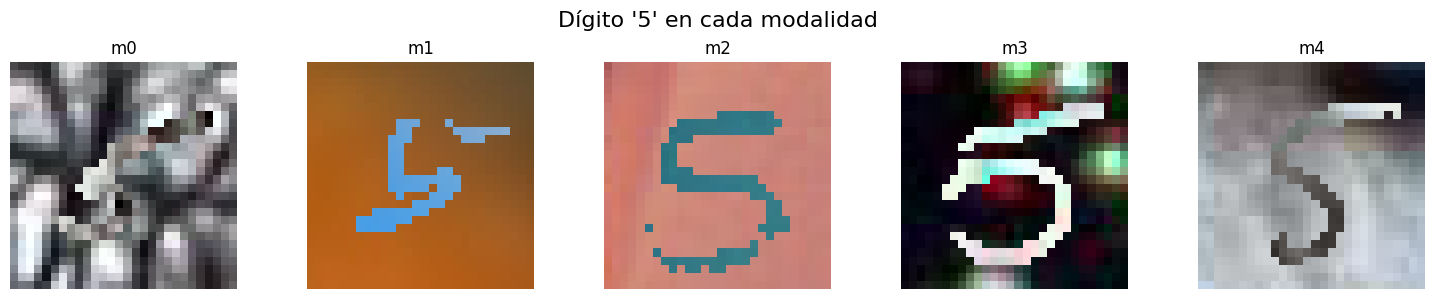

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Definir carpeta base (desde donde se ejecuta el notebook)
base_dir = "train"

# Detectar automáticamente todas las modalidades m0, m1, ..., m4
modalities = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("m")
])

print("Modalidades detectadas:", modalities)

# Elegir qué dígito mostrar (0 al 9)
target_label = "5"  

images = []

# Recorrer cada modalidad
for mod in modalities:
    folder_path = os.path.join(base_dir, mod)

    # Filtrar imágenes con la etiqueta deseada 
    all_images = [
        f for f in os.listdir(folder_path)
        if f.endswith(".png") and f.split(".")[1] == target_label
    ]

    if not all_images:
        print(f"No se encontraron imágenes con etiqueta {target_label} en {mod}")
        continue

    # Elegir una imagen aleatoria de esa etiqueta
    img_file = random.choice(all_images)
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    images.append((mod, img))

# Mostrar las imágenes seleccionadas
plt.figure(figsize=(15, 3))
for idx, (mod, img) in enumerate(images):
    plt.subplot(1, len(images), idx + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{mod}")
    plt.axis("off")

plt.suptitle(f"Dígito '{target_label}' en cada modalidad", fontsize=16)
plt.tight_layout()
plt.show()

### 2. Análisis exploratorio

,m0,m1,m2,m3,m4
0,5923,5923,5923,5923,5923
1,6742,6742,6742,6742,6742
2,5958,5958,5958,5958,5958
3,6131,6131,6131,6131,6131
4,5842,5842,5842,5842,5842
5,5421,5421,5421,5421,5421
6,5918,5918,5918,5918,5918
7,6265,6265,6265,6265,6265
8,5851,5851,5851,5851,5851
9,5949,5949,5949,5949,5949


<Figure size 1200x600 with 0 Axes>

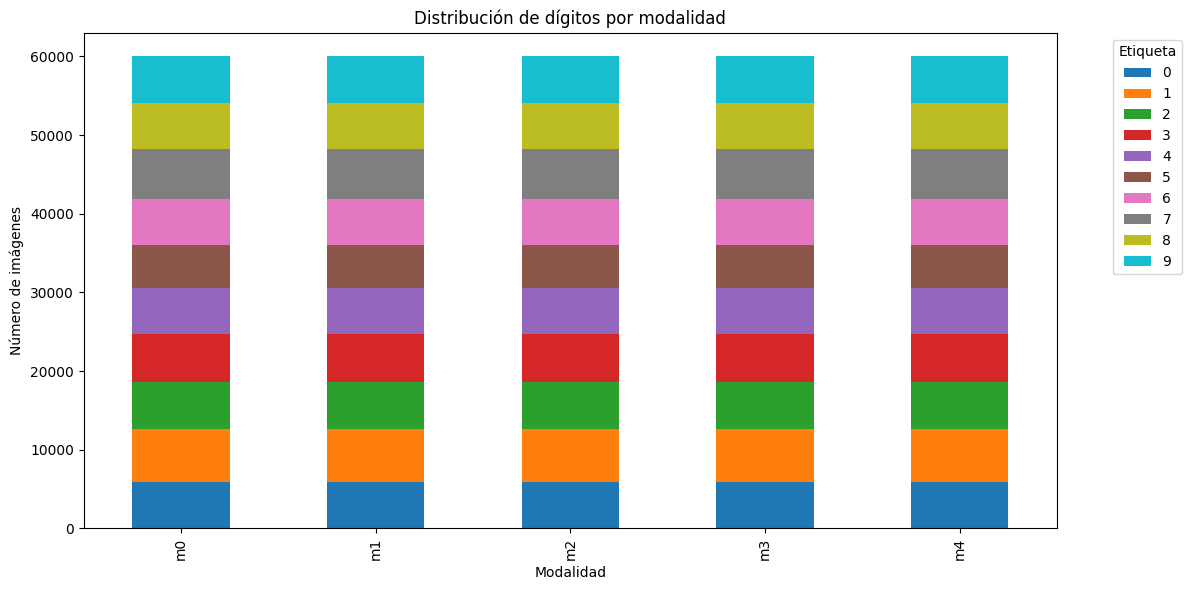

Resoluciones detectadas: {(28, 28)}


In [16]:
import os
from collections import defaultdict, Counter
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Base path donde están tus datos
base_dir = "./train"

# Detectar modalidades m0, m1, ...
modalities = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("m")
])

# Contar imágenes por etiqueta en cada modalidad
distribution = defaultdict(Counter)
resolutions = set()

for mod in modalities:
    folder = os.path.join(base_dir, mod)
    for file in os.listdir(folder):
        if file.endswith(".png"):
            label = file.split(".")[1]
            distribution[mod][label] += 1

            # Guardar resolución (tamaño) de una imagen
            img_path = os.path.join(folder, file)
            with Image.open(img_path) as img:
                resolutions.add(img.size)

# Mostrar tabla
df = pd.DataFrame(distribution).fillna(0).astype(int).sort_index()
display(df)

# Mostrar gráfico
plt.figure(figsize=(12, 6))
df.T.plot(kind="bar", stacked=True, colormap="tab10", figsize=(12,6))
plt.title("Distribución de dígitos por modalidad")
plt.xlabel("Modalidad")
plt.ylabel("Número de imágenes")
plt.legend(title="Etiqueta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Ver resoluciones únicas
print("Resoluciones detectadas:", resolutions)


El conjunto de datos está organizado en 5 modalidades (m0 a m4). Se realizó un análisis de distribución de etiquetas y se encontró que cada modalidad contiene un número equilibrado de imágenes por clase (0–9), lo que indica que el dataset está balanceado. Además, todas las imágenes tienen una resolución uniforme de 28×28 píxeles.

,m0,m1,m2,m3,m4
train,60000,60000,60000,60000,60000
test,10000,10000,10000,10000,10000


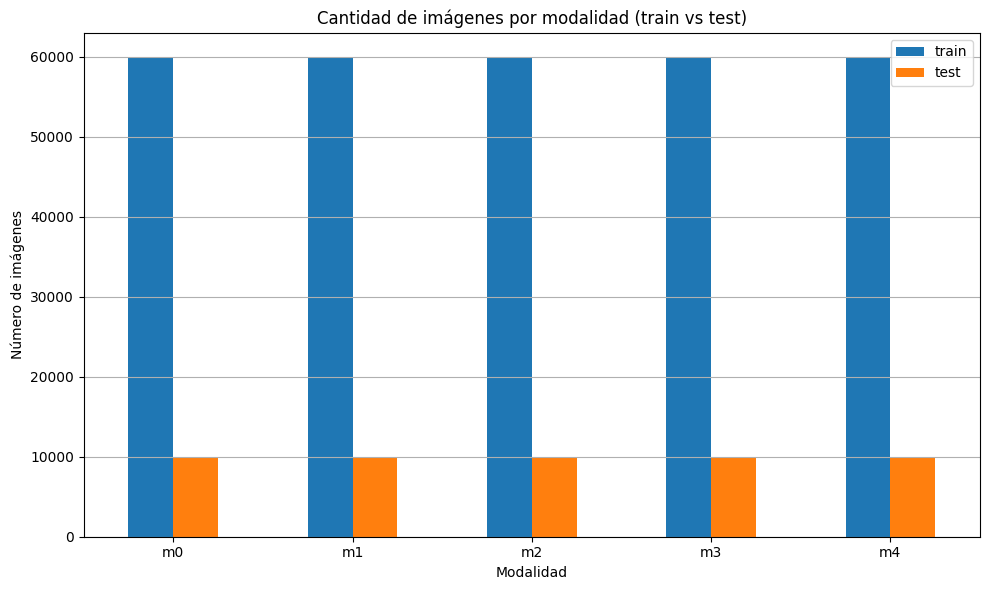

In [15]:
import os
from collections import defaultdict

# Directorios principales
root_dirs = ["train", "test"]
conteo = defaultdict(lambda: defaultdict(int))

for root in root_dirs:
    base_dir = f"./{root}"
    modalities = sorted([
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("m")
    ])
    
    for mod in modalities:
        folder_path = os.path.join(base_dir, mod)
        num_imgs = len([f for f in os.listdir(folder_path) if f.endswith(".png")])
        conteo[root][mod] = num_imgs

# Mostrar tabla
import pandas as pd
df_conteo = pd.DataFrame(conteo).T
display(df_conteo)

# Gráfico
import matplotlib.pyplot as plt
df_conteo.T.plot(kind="bar", figsize=(10,6))
plt.title("Cantidad de imágenes por modalidad (train vs test)")
plt.xlabel("Modalidad")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Modelos

Modelo 1

In [7]:
# Directorios
train_dir = "train"
test_dir = "test"

# Generador de datos con normalización
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generador para entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=64,
    class_mode='categorical'
)

# Generador para prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 300000 images belonging to 5 classes.
Found 50000 images belonging to 5 classes.


In [8]:
# Definir modelo
model1 = Sequential()

# Bloque 1
model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)))
model1.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Bloque 2
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Bloque 3
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Clasificación
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(5, activation='softmax'))  # 5 clases (m0...m4)

# Compilar
model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model1.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,237 (1.66 MB)

 Trainable params: 435,237 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Entrenar modelo con generadores
history1 = model1.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

Epoch 1/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 654s 139ms/step - accuracy: 0.9156 - loss: 0.2020 - val_accuracy: 0.9749 - val_loss: 0.0974
Epoch 2/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 616s 131ms/step - accuracy: 0.9947 - loss: 0.0181 - val_accuracy: 0.9979 - val_loss: 0.0065
Epoch 3/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 613s 131ms/step - accuracy: 0.9971 - loss: 0.0101 - val_accuracy: 0.9978 - val_loss: 0.0063
Epoch 4/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 616s 131ms/step - accuracy: 0.9977 - loss: 0.0086 - val_accuracy: 0.9981 - val_loss: 0.0056
Epoch 5/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 621s 132ms/step - accuracy: 0.9976 - loss: 0.0092 - val_accuracy: 0.9981 - val_loss: 0.0054
Epoch 6/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 619s 132ms/step - accuracy: 0.9983 - loss: 0.0061 - val_accuracy: 0.9982 - val_loss: 0.0056
Epoch 7/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 595s 127ms/step - accuracy: 0.9985 - loss: 0.0056 - val_accuracy: 0.9997 - val_loss: 7.3762e-04
Epoch 8/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 588s 125ms/step 

782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.9996 - loss: 0.0014
Precisión en test: 0.9997
Pérdida en test: 0.0009


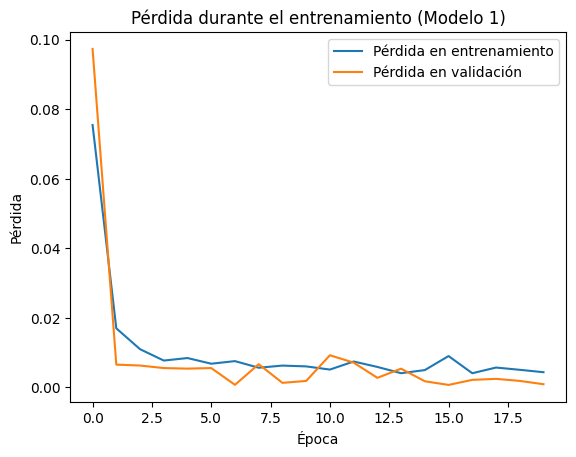

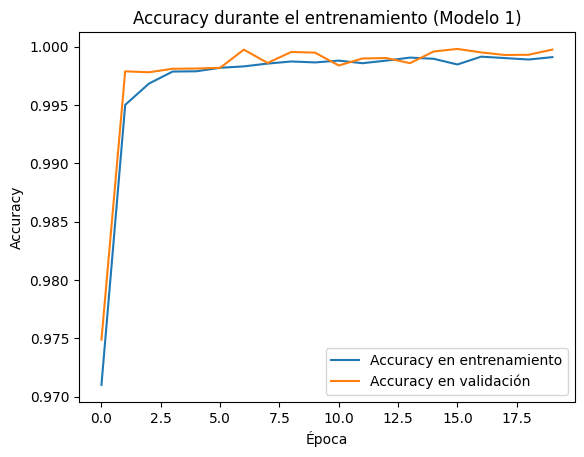

In [10]:
# Evaluar en el set de prueba
test_loss, test_acc = model1.evaluate(test_generator)
print(f"Precisión en test: {test_acc:.4f}")
print(f"Pérdida en test: {test_loss:.4f}")

# Graficar pérdida
plt.plot(history1.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history1.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento (Modelo 1)')
plt.show()

# Graficar accuracy
plt.plot(history1.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history1.history['val_accuracy'], label='Accuracy en validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy durante el entrenamiento (Modelo 1)')
plt.show()


Modelo 2

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Definir Modelo 2 (más profundo + dropout)
model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Regularización para evitar overfitting
    layers.Dense(5, activation='softmax')  # 5 clases
])

# Compilar
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping para cortar entrenamiento si no mejora
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # espera 5 epochs sin mejora
    restore_best_weights=True
)

In [12]:
history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stop]
)

Epoch 1/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 734s 156ms/step - accuracy: 0.9365 - loss: 0.1560 - val_accuracy: 0.9983 - val_loss: 0.0062
Epoch 2/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 678s 145ms/step - accuracy: 0.9939 - loss: 0.0208 - val_accuracy: 0.9978 - val_loss: 0.0065
Epoch 3/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 702s 150ms/step - accuracy: 0.9971 - loss: 0.0095 - val_accuracy: 0.9994 - val_loss: 0.0017
Epoch 4/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 682s 145ms/step - accuracy: 0.9983 - loss: 0.0063 - val_accuracy: 0.9994 - val_loss: 0.0017
Epoch 5/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 669s 143ms/step - accuracy: 0.9983 - loss: 0.0059 - val_accuracy: 0.9991 - val_loss: 0.0029
Epoch 6/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 720s 154ms/step - accuracy: 0.9984 - loss: 0.0067 - val_accuracy: 0.9985 - val_loss: 0.0043
Epoch 7/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 706s 150ms/step - accuracy: 0.9987 - loss: 0.0058 - val_accuracy: 0.9996 - val_loss: 0.0014
Epoch 8/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 687s 146ms/step - ac

782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.9998 - loss: 4.8299e-04
Precisión en test (Modelo 2): 0.9998
Pérdida en test (Modelo 2): 0.0005


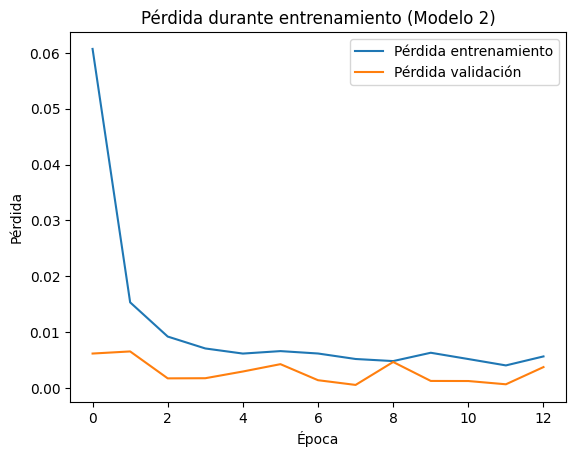

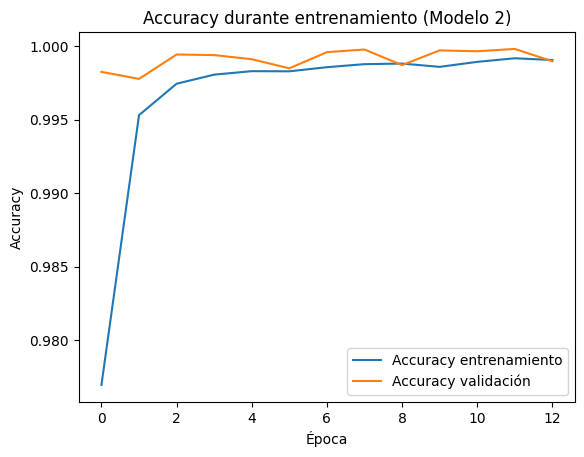

In [13]:
# Evaluar
test_loss2, test_acc2 = model2.evaluate(test_generator)
print(f"Precisión en test (Modelo 2): {test_acc2:.4f}")
print(f"Pérdida en test (Modelo 2): {test_loss2:.4f}")

# Gráfica de pérdida
plt.plot(history2.history['loss'], label='Pérdida entrenamiento')
plt.plot(history2.history['val_loss'], label='Pérdida validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante entrenamiento (Modelo 2)')
plt.show()

# Gráfica de accuracy
plt.plot(history2.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Accuracy validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy durante entrenamiento (Modelo 2)')
plt.show()
